In [20]:
import pandas as pd
import numpy as np

orcs = pd.read_csv('orcs_cleaned.csv', index_col=0, encoding='utf-8')
orcs.family = orcs.family.astype('int')
orcs 

In [21]:
orcs.describe()

,age,family
count,67443.000000,67443.000000
mean,34.029076,0.743457
std,8.536960,0.436728
min,18.000000,0.000000
25%,27.000000,0.000000
50%,32.000000,1.000000
75%,41.000000,1.000000
max,68.000000,1.000000


<AxesSubplot:>

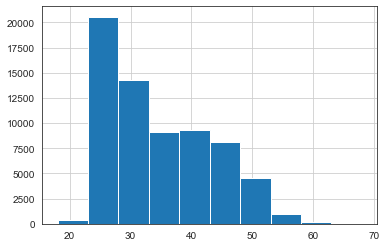

In [22]:
orcs.age.hist()

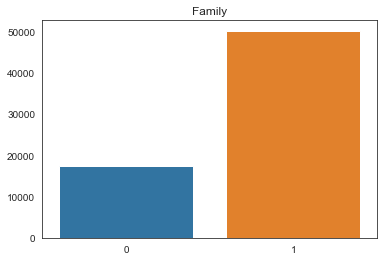

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
ax = sns.countplot(x='family', data=orcs).set_title('Family')
ax.axes.set_xlabel('')
ax.axes.set_ylabel('')
plt.show()

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

targets = orcs.mil_rank_cl
targets = LabelEncoder().fit_transform(targets) 

features = orcs.drop(['mil_rank_cl', 'age_range'], axis=1)
features['edu_lvl_cl'] = LabelEncoder().fit_transform(features['edu_lvl_cl'])
features = pd.get_dummies(features, columns=['family', 'region', 'nationality'])

features = MinMaxScaler().fit_transform(features)
features.shape

(67443, 113)

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, targets, random_state=50)

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


dict_classifiers = {
        
    "Nearest Neighbors": 
            {
              'classifier': KNeighborsClassifier(),
              'name': 'KNN',
              'params': [
                          {
                              'n_neighbors': [5, 10, 20],
                              'leaf_size': [3, 30]
                          }
                        ] 
            },

    "Decision Tree":
            {
                'classifier': DecisionTreeClassifier(),
                'name': 'DT',
                'params': [
                            {
                                'max_depth': [10, 20, 30, None],
                                'criterion': ['gini', 'entropy'],
                                'splitter': ['best', 'random'],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 5]
                            }
                          ] 
            },
            
    "Random Forest": 
            {
                'classifier': RandomForestClassifier(),
                'name': 'RF',
                'params': [
                            {
                                'max_depth': [10, 50, 100],
                                'min_samples_leaf': [10, 50, 100],
                                'n_estimators': [50, 100, 200]
                            }
                          ]
            },

    "Naive Bayes": 
            {
                'classifier': GaussianNB(),
                'name': 'NB',
                'params': [
                            {
                                'var_smoothing': np.logspace(0, -9, 10)
                            }
                          ]                
            },
            
    "Logistic Regression":
            {
                'classifier': LogisticRegression(),
                'name': 'LR',
                'params': [
                            {
                                "C": np.logspace(-3, 3, 5), 
                                "penalty": ["l1", "l2"] 
                                # l1 lasso l2 ridge
                            }
                          ]                
            },
            
    "Multilayer Perceptron":
            {
                'classifier': MLPClassifier(),
                'name': 'MLP',
                'params': [
                            {
                                'hidden_layer_sizes': [(50, 50, 50), 
                                                       (50, 100, 50), 
                                                       (100,)]
                            }
                          ]                
            },
            
    "Gradient Boosting":
            {
                'classifier': GradientBoostingClassifier(),
                'name': 'GB',
                'params': [
                            {
                                
                            }
                          ]                
            }
}

In [27]:
from sklearn.model_selection import learning_curve 


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1):
    """
        Generate a simple plot of the test and traning learning curve.

        Parameters
        ----------
        estimator : object type that implements the "fit" and "predict" methods
            An object of that type which is cloned for each validation.

        title : string
            Title for the chart.

        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape (n_samples) or (n_samples, n_features), optional
            Target relative to X for classification or regression;
            None for unsupervised learning.

        ylim : tuple, shape (ymin, ymax), optional
            Defines minimum and maximum yvalues plotted.

        cv : integer, cross-validation generator, optional
            If an integer is passed, it is the number of folds (defaults to 3).
            Specific cross-validation objects can be passed, see
            sklearn.cross_validation module for the list of possible objects

        n_jobs : integer, optional
            Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [28]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle


num_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, X_test, Y_test, classifier, verbose=True):
    """
        Classify the data using the given classifier

        Args:
            X_train (_type_): Training data
            Y_train (_type_): Training labels
            X_test (_type_): Test data
            Y_test (_type_): Test labels
            classifier (_type_): Classifier to use
            verbose (bool, optional): Print progress to stdout. Defaults to True.

        Returns: (_type_): Classifier score        
    """
    t_start = time.perf_counter()
    grid = GridSearchCV(estimator=dict_classifiers[classifier]['classifier'], 
                        param_grid=dict_classifiers[classifier]['params'], 
                        cv=3, n_jobs=3, verbose=verbose, refit=True, scoring='accuracy')     
                                 
    estimator = grid.fit(X_train, Y_train)
    t_diff = time.perf_counter() - t_start
    
    filename = f'models/{dict_classifiers[classifier]["name"]}.sav'
    pickle.dump(estimator, open(filename, 'wb'))    
    
    train_score = estimator.score(X_train, Y_train)
    test_score = estimator.score(X_test, Y_test)
    
    predicted = estimator.predict(x_test)
    expected = y_test

    confusion = confusion_matrix(expected, predicted)
    print(confusion, end="\n\n")
    
    names = [str(i) for i in orcs.mil_rank_cl.unique()]
    print(classification_report(expected, predicted, target_names=names), end="\n\n")
    # Accuracy - number of correct predictions over all predictions
    # Precision - how many of the positive predictions made are correct (true positives)
    # Recall - how many of the positive cases the classifier correctly predicted, 
    #          over all the positive cases in the data
    # F1 - harmonic mean of precision and recall
    
    results = pd.Series()
    
    results.loc[0] = classifier
    results.loc[1] = train_score
    results.loc[2] = test_score
    results.loc[3] = t_diff
    
    if verbose:
        print("Trained {c} in {f:.2f} s".format(c=classifier, f=t_diff))
    
    plot_learning_curve(estimator, "{}".format(classifier), X_train, Y_train, cv=3, n_jobs=3)
        
    return results

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[[  166   831     0     7   891]
 [  122 10925     0    39   803]
 [    1     0     0     0    11]
 [   42   897     0    27   445]
 [  106   387     0    10  1151]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.38      0.09      0.14      1895
                Прапорщики и мичманы       0.84      0.92      0.88     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.33      0.02      0.04      1411
                      высшие офицеры       0.35      0.70      0.46      1654

                            accuracy                           0.73     16861
                           macro avg       0.38      0.34      0.30     16861
                        weighted avg       0.69      0.73      0.68     16861


Trained Decision Tree in 114.19 s


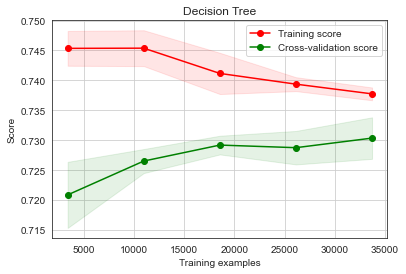

In [29]:
import warnings

warnings.filterwarnings("ignore")

df_results = pd.DataFrame(np.zeros(shape=(0, 4)), 
                          columns = ['classifier', 'train_score', 'test_score', 'training_time'])

dt = batch_classify(x_train, y_train, x_test, y_test, 'Decision Tree')

df_results = df_results.append({'classifier': dt[0], 'train_score': dt[1], 
                                'test_score': dt[2], 'training_time': dt[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[[  422   997     0    46   430]
 [  353 11061     0    90   385]
 [    3     0     0     0     9]
 [  130   915     0    90   276]
 [  372   548     0    53   681]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.33      0.22      0.27      1895
                Прапорщики и мичманы       0.82      0.93      0.87     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.32      0.06      0.11      1411
                      высшие офицеры       0.38      0.41      0.40      1654

                            accuracy                           0.73     16861
                           macro avg       0.37      0.33      0.33     16861
                        weighted avg       0.68      0.73      0.69     16861


Trained Nearest Neighbors in 111.74 s


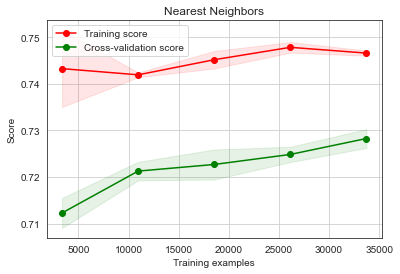

In [30]:
warnings.filterwarnings("ignore")

knn = batch_classify(x_train, y_train, x_test, y_test, 'Nearest Neighbors')

df_results = df_results.append({'classifier': knn[0], 'train_score': knn[1], 
                                'test_score': knn[2], 'training_time': knn[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[[    0  1895     0     0     0]
 [    0 11889     0     0     0]
 [    0    12     0     0     0]
 [    0  1411     0     0     0]
 [    0  1654     0     0     0]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.00      0.00      0.00      1895
                Прапорщики и мичманы       0.71      1.00      0.83     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.00      0.00      0.00      1411
                      высшие офицеры       0.00      0.00      0.00      1654

                            accuracy                           0.71     16861
                           macro avg       0.14      0.20      0.17     16861
                        weighted avg       0.50      0.71      0.58     16861


Trained Naive Bayes in 8.95 s


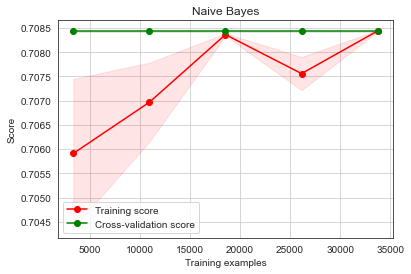

In [31]:
warnings.filterwarnings("ignore")

nb = batch_classify(x_train, y_train, x_test, y_test, 'Naive Bayes')

df_results = df_results.append({'classifier': nb[0], 'train_score': nb[1], 
                                'test_score': nb[2], 'training_time': nb[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[[  259  1153     0    24   459]
 [  223 11265     0    49   352]
 [    0     1     0     0    11]
 [  115  1063     0    39   194]
 [  277   712     0    30   635]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.30      0.14      0.19      1895
                Прапорщики и мичманы       0.79      0.95      0.86     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.27      0.03      0.05      1411
                      высшие офицеры       0.38      0.38      0.38      1654

                            accuracy                           0.72     16861
                           macro avg       0.35      0.30      0.30     16861
                        weighted avg       0.65      0.72      0.67     16861


Trained Logistic Regression in 22.42 s


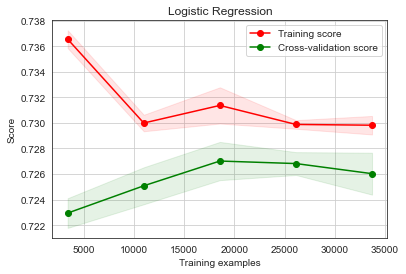

In [32]:
warnings.filterwarnings("ignore")

lr = batch_classify(x_train, y_train, x_test, y_test, 'Logistic Regression')

df_results = df_results.append({'classifier': lr[0], 'train_score': lr[1], 
                                'test_score': lr[2], 'training_time': lr[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[[  382   966     0     7   540]
 [  248 11116     0    23   502]
 [    3     0     1     0     8]
 [  102   964     0    25   320]
 [  319   458     0    18   859]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.36      0.20      0.26      1895
                Прапорщики и мичманы       0.82      0.93      0.88     11889
                     младшие офицеры       1.00      0.08      0.15        12
                     старшие офицеры       0.34      0.02      0.03      1411
                      высшие офицеры       0.39      0.52      0.44      1654

                            accuracy                           0.73     16861
                           macro avg       0.58      0.35      0.35     16861
                        weighted avg       0.69      0.73      0.69     16861


Trained Gradient Boosting in 220.58 s


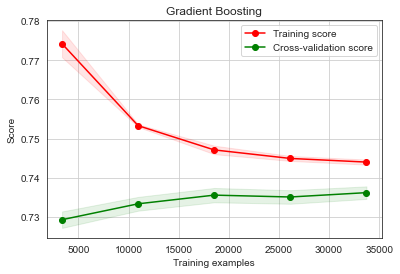

In [33]:
warnings.filterwarnings("ignore")

gbc = batch_classify(x_train, y_train, x_test, y_test, 'Gradient Boosting')

df_results = df_results.append({'classifier': gbc[0], 'train_score': gbc[1], 
                                'test_score': gbc[2], 'training_time': gbc[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[[  356  1001     0    10   528]
 [  238 11154     0    33   464]
 [    3     0     0     0     9]
 [   86   962     0    29   334]
 [  287   500     0    16   851]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.37      0.19      0.25      1895
                Прапорщики и мичманы       0.82      0.94      0.87     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.33      0.02      0.04      1411
                      высшие офицеры       0.39      0.51      0.44      1654

                            accuracy                           0.73     16861
                           macro avg       0.38      0.33      0.32     16861
                        weighted avg       0.68      0.73      0.69     16861


Trained Random Forest in 196.19 s


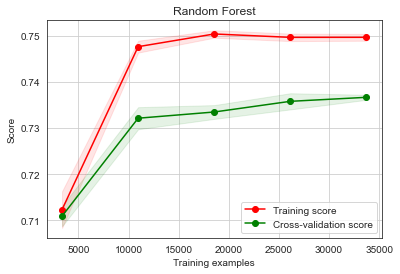

In [34]:
warnings.filterwarnings("ignore")

rf = batch_classify(x_train, y_train, x_test, y_test, 'Random Forest')

df_results = df_results.append({'classifier': rf[0], 'train_score': rf[1], 
                                'test_score': rf[2], 'training_time': rf[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[[  272  1020     2    20   581]
 [  196 11137     0    41   515]
 [    2     0     0     0    10]
 [   61   959     0    56   335]
 [  241   523     2    25   863]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.35      0.14      0.20      1895
                Прапорщики и мичманы       0.82      0.94      0.87     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.39      0.04      0.07      1411
                      высшие офицеры       0.37      0.52      0.44      1654

                            accuracy                           0.73     16861
                           macro avg       0.39      0.33      0.32     16861
                        weighted avg       0.69      0.73      0.69     16861


Trained Multilayer Perceptron in 343.22 s


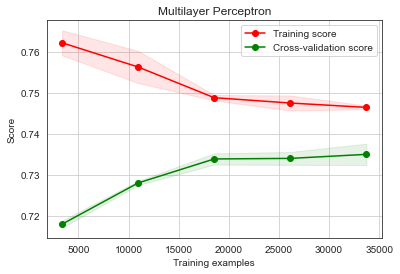

In [35]:
warnings.filterwarnings("ignore")

mlp = batch_classify(x_train, y_train, x_test, y_test, 'Multilayer Perceptron')

df_results = df_results.append({'classifier': mlp[0], 'train_score': mlp[1], 
                                'test_score': mlp[2], 'training_time': mlp[3]}, 
                                ignore_index=True)

In [36]:
df_results = df_results.sort_values(by=['test_score'], ascending=False)
df_results

,classifier,train_score,test_score,training_time
5,Random Forest,0.749199,0.734832,196.194740
4,Gradient Boosting,0.741884,0.734417,220.583827
6,Multilayer Perceptron,0.744909,0.731155,343.219352
0,Decision Tree,0.737278,0.727656,114.188104
1,Nearest Neighbors,0.746570,0.726766,111.742513
3,Logistic Regression,0.728698,0.723445,22.418447
2,Naive Bayes,0.708434,0.705118,8.945848
